In [6]:
#importing required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
import torch
import itertools
import os

In [7]:
df = pd.read_pickle('../data/raw/merged_training.pkl')

In [8]:
df=df.reset_index()

In [9]:
#Defining class for each emotion
df['labels'] = df['emotions'].factorize()[0]
df.head()


,index,text,emotions,labels
0,27383,i feel awful about it too because it s my job ...,sadness,0
1,110083,im alone i feel awful,sadness,0
2,140764,ive probably mentioned this before but i reall...,joy,1
3,100071,i was feeling a little low few days back,sadness,0
4,2837,i beleive that i am much more sensitive to oth...,love,2


In [10]:
uniquevalues = pd.unique(df[['emotions']].values.ravel())
df_unique=pd.DataFrame(uniquevalues,columns=['Emotion'])


In [11]:
df_unique

,Emotion
0,sadness
1,joy
2,love
3,anger
4,fear
5,surprise


In [12]:
df_unique.to_csv('../models/emotions.csv',index=False)

In [23]:
#importing libraries for models and nlp tasks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV



### TF-IDF Vectorization for models

In [24]:
tfidf_vectorizer = TfidfVectorizer()

In [25]:
y =df['labels']

In [26]:
#Train test split of the data
Xtrain, Xtest, ytrain, ytest = train_test_split(df['text'], y, test_size=0.3,random_state=1)
Xtrain_tfidf = tfidf_vectorizer.fit_transform(Xtrain)
Xtest_tfidf = tfidf_vectorizer.transform(Xtest)

In [5]:
pickle.dump(tfidf, open('../models/tfidf_vect.pkl', 'wb'))

### Different models 

  
 The models I am exploring to find a suitable classification algorithm for the dataset are:
 1. Logistic Regression
 2. Random Forest Classifier
 3. K- Nearest Neighbours
 4. Support Vector machine
 5. XGB
 
The models like KNN, Random forest and XGB are suitable for multiclass classification. Some models which are used for binary classification like logistic regression, SVM can be expanded to the multiclass classification by breaking down the multiclass into small sets of binary classifications. 
  There are two common approaches to use them for multi-class classification: one-vs-rest and one-vs-one.
 In one-vs-rest, each classifier (binary) is trained to determine whether or not an example is part of class  or not. To predict the class for a new example , we run all  classifiers on and choose the class with the highest score. One main drawback is that when there are lots of classes, each binary classifier sees a highly imbalanced dataset, which may degrade performance.
 In one-vs-one, we train separate binary classification models, one for each possible pair of classes. To predict the class for a new example , we run all classifiers on  and choose the class with the most “votes.” A major drawback is that there can exist fairly large regions in the decision space with ties for the class with the most number of votes.
 

##### Logistic Regression

In [27]:
#Logistic Regression with One vs Rest
lr_ovr = LogisticRegression(multi_class='ovr', solver='liblinear')
lr_ovr.fit(Xtrain_tfidf, ytrain)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [28]:
ypred_lr_ovr=lr_ovr.predict(Xtest_tfidf)

In [29]:
len(ypred_lr_ovr)

125043

In [26]:
tr_acc_lr_ovr = lr_ovr.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_ovr =  accuracy_score(ytest,ypred_lr_ovr) * 100
print(tr_acc_lr_ovr,test_acc_lr_ovr)

91.93566076924658 89.82749934022695


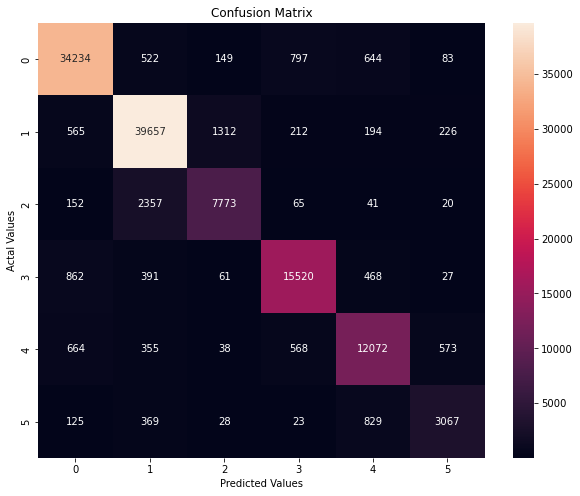

In [27]:
cm = confusion_matrix(ytest, ypred_lr_ovr)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [28]:
print(classification_report(ytest,ypred_lr_ovr, digits=3))

              precision    recall  f1-score   support

           0      0.935     0.940     0.938     36429
           1      0.909     0.940     0.924     42166
           2      0.830     0.747     0.786     10408
           3      0.903     0.896     0.899     17329
           4      0.847     0.846     0.847     14270
           5      0.768     0.691     0.727      4441

    accuracy                          0.898    125043
   macro avg      0.865     0.843     0.854    125043
weighted avg      0.897     0.898     0.897    125043



In [31]:
pickle.dump(lr_ovr, open(working_directory+'/models/lr_ovr.pkl', 'wb'))

In [30]:
#Logistic Regression with multinomial
lr_mn = LogisticRegression(multi_class='multinomial', solver='lbfgs')
lr_mn.fit(Xtrain_tfidf, ytrain)


/Users/phanisingaraju/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='multinomial')

In [31]:
ypred_lr_mn=lr_mn.predict(Xtest_tfidf)

In [32]:
tr_acc_lr_mn = lr_ovr.score(Xtrain_tfidf, ytrain)*100
test_acc_lr_mn =  accuracy_score(ytest,ypred_lr_mn) * 100
print(tr_acc_lr_mn,test_acc_lr_mn)

91.93566076924658 90.089009380773


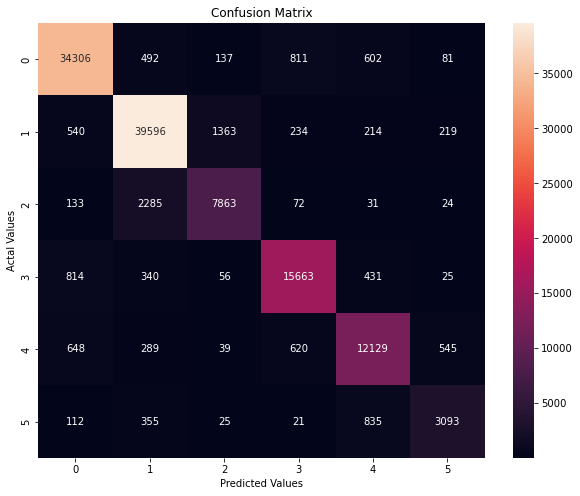

In [33]:
cm = confusion_matrix(ytest, ypred_lr_mn)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [34]:
pickle.dump(lr_mn, open('../models/lr_mn.pkl', 'wb'))

##### Random Forest

In [151]:
rf = RandomForestClassifier()
rf.fit(Xtrain_tfidf, ytrain)


RandomForestClassifier()

In [152]:
rf.get_params()
#rf.n_classes_

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [153]:
ypred_rf=rf.predict(Xtest_tfidf)

In [154]:
tr_acc_rf = rf.score(Xtrain_tfidf, ytrain)*100
test_acc_rf =  accuracy_score(ytest,ypred_rf) * 100
print(tr_acc_rf,test_acc_rf)

96.26412947361928 85.90244955735227


In [155]:
pickle.dump(rf, open('../models/rf_Basic.pkl', 'wb'))

In [170]:
# tuning max_depth in the tree

param1= { 
         'max_depth':[10,20,30,40,50,60,70,80,90,100],
        # 'min_samples_split':[2,4,8],
         'criterion' : ['entropy']
    
}

gridcv1 = GridSearchCV(rf, param1, cv = 2, verbose = 1, 
                      n_jobs = -1)

In [171]:
%%time

grid_param1=gridcv1.fit(Xtrain_tfidf, ytrain)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
CPU times: user 10min 38s, sys: 975 ms, total: 10min 39s
Wall time: 24min 6s


In [178]:
res= grid_param1.cv_results_['mean_test_score']

#epochs = len(results['validation_0']['auc'])
#x_axis = range(0, epochs)

In [179]:
res

array([0.35266618, 0.42765778, 0.50930197, 0.55796769, 0.60481345,
       0.64623363, 0.69393966, 0.74184449, 0.77748264, 0.80397647])

In [172]:
print(grid_param1.best_score_, grid_param1.best_params_)

0.8039764742978963 {'criterion': 'entropy', 'max_depth': 100}


In [180]:
ypred_rf_param1=grid_param1.predict(Xtest_tfidf)

In [181]:
tr_acc_rf_param1 = grid_param1.score(Xtrain_tfidf, ytrain)*100
test_acc_rf_param1 =  accuracy_score(ytest,ypred_rf_param1) * 100
print(tr_acc_rf_param1,test_acc_rf_param1)

90.29324869930012 80.0956470973985


In [182]:
param2= { 
         'max_depth':[100,110,120],
         'min_samples_split':[2,4,8],
         'criterion' : ['entropy'],
         'min_samples_leaf' : [1, 3, 4],
         'n_estimators':[50,100,200,300]
    
}

gridcv2 = GridSearchCV(rf, param2, cv = 2, verbose = 1, scoring="f1_macro",
                      n_jobs = -1)

In [183]:
%%time

grid_param2=gridcv2.fit(Xtrain_tfidf, ytrain)

Fitting 2 folds for each of 108 candidates, totalling 216 fits


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 6min 6s, sys: 1.84 s, total: 6min 8s
Wall time: 4h 16min 10s


From stackoverflow: Removing n_jobs=-1 in GridSearchCV solves the issue  of above warning

In [185]:
print(grid_param2.best_score_, grid_param2.best_params_)

0.7819183453025129 {'criterion': 'entropy', 'max_depth': 120, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300}


In [186]:
ypred_rf_param2=grid_param2.predict(Xtest_tfidf)

In [187]:
tr_acc_rf_param2 = grid_param2.score(Xtrain_tfidf, ytrain)*100
test_acc_rf_param2 =  accuracy_score(ytest,ypred_rf_param2) * 100
print(tr_acc_rf_param2,test_acc_rf_param2)

89.22496675106068 84.58610238078101


In [189]:
pickle.dump(grid_param2, open('../models/rf_hp.pkl', 'wb'))

##### SVM Classifier

In [91]:
%%time
svm = SVC( kernel ='linear',C = 1, decision_function_shape='ovo')
svm.fit(Xtrain_tfidf, ytrain)
#Run time approximately 4hrs

SVC(C=1, decision_function_shape='ovo', kernel='linear')

In [ ]:
pickle.dump(svm, open('../models/svm.pkl', 'wb'))

In [15]:
ypred_svm=svm.predict(Xtest_tfidf)

In [16]:
tr_acc_svm = svm.score(Xtrain_tfidf, ytrain)*100
test_acc_svm =  accuracy_score(ytest,ypred_svm) * 100
print(tr_acc_svm,test_acc_svm)

92.56219024834971 89.17252465151988


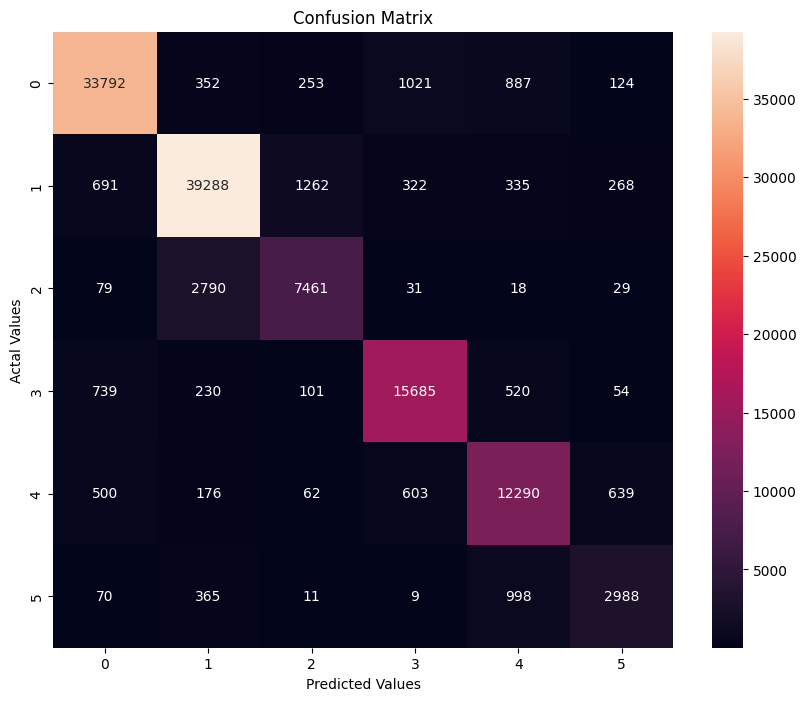

In [32]:
cm = confusion_matrix(ytest, ypred_svm)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [33]:
print(classification_report(ytest,ypred_svm, digits=3))

              precision    recall  f1-score   support

           0      0.942     0.928     0.935     36429
           1      0.909     0.932     0.920     42166
           2      0.815     0.717     0.763     10408
           3      0.888     0.905     0.896     17329
           4      0.817     0.861     0.838     14270
           5      0.728     0.673     0.700      4441

    accuracy                          0.892    125043
   macro avg      0.850     0.836     0.842    125043
weighted avg      0.891     0.892     0.891    125043



##### KNN Classifier

In [34]:
%%time
k_range = [25,50,100,150,200,300,400]
train_scores = []
test_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knn=neigh.fit(Xtrain_tfidf,ytrain)
    tr_acc_knn = knn.score(Xtrain_tfidf, ytrain)*100
    ypred_knn = knn.predict(Xtest_tfidf)
    accuracy_knn = accuracy_score(ytest,ypred_knn)
    test_acc_knn = accuracy_knn * 100
    train_scores.append(tr_acc_knn)
    test_scores.append(test_acc_knn)



In [22]:
dif=[train - test for train,test in zip(train_scores, test_score)]
print(dif)

[2.739999999999995, 1.465999999999994, 0.8770000000000095, 0.6479999999999961, 0.48799999999999955, 0.33799999999999386, 0.25099999999999056]


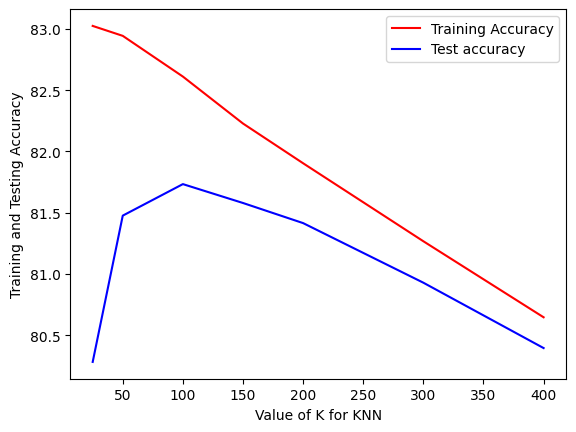

In [24]:
plt.plot(k, train_scores,color='r',label='Training Accuracy')
plt.plot(k, test_scores,color='b',label='Test accuracy')


plt.xlabel('Value of K for KNN')
plt.ylabel('Training and Testing Accuracy')
plt.legend()
plt.show()

In [28]:
plt.savefig('knn_elbow.png')

<Figure size 640x480 with 0 Axes>

In [25]:
neigh = KNeighborsClassifier(n_neighbors=100)
knn=neigh.fit(Xtrain_tfidf,ytrain)
tr_acc_knn = knn.score(Xtrain_tfidf, ytrain)*100
ypred_knn = knn.predict(Xtest_tfidf)
accuracy_knn = accuracy_score(ytest,ypred_knn)
test_acc_knn = accuracy_knn * 100

print(tr_acc_knn,test_acc_knn)

82.61106503156638 81.73428340650815


In [26]:
pickle.dump(knn, open('../models/knn.pkl', 'wb'))

##### XGB Classifier

Hyper parameter tuning 

Tuning n_estimators:

In [35]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=1000, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 6,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)

In [36]:
eval_set = [(Xtrain_tfidf, ytrain),(Xtest_tfidf, ytest)]

In [37]:
xgb.fit(Xtrain_tfidf, ytrain, eval_metric='auc', eval_set=eval_set, verbose=True)


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.60817	validation_1-auc:0.60675
[1]	validation_0-auc:0.67470	validation_1-auc:0.67149
[2]	validation_0-auc:0.73739	validation_1-auc:0.73391
[3]	validation_0-auc:0.78616	validation_1-auc:0.78410
[4]	validation_0-auc:0.82325	validation_1-auc:0.82093
[5]	validation_0-auc:0.84722	validation_1-auc:0.84505
[6]	validation_0-auc:0.86439	validation_1-auc:0.86290
[7]	validation_0-auc:0.87846	validation_1-auc:0.87687
[8]	validation_0-auc:0.89221	validation_1-auc:0.89018
[9]	validation_0-auc:0.90124	validation_1-auc:0.89935
[10]	validation_0-auc:0.91254	validation_1-auc:0.91053
[11]	validation_0-auc:0.92122	validation_1-auc:0.91926
[12]	validation_0-auc:0.93097	validation_1-auc:0.92872
[13]	validation_0-auc:0.93653	validation_1-auc:0.93422
[14]	validation_0-auc:0.93982	validation_1-auc:0.93761
[15]	validation_0-auc:0.94356	validation_1-auc:0.94139
[16]	validation_0-auc:0.94657	validation_1-auc:0.94414
[17]	validation_0-auc:0.94649	validation_1-auc:0.94400
[18]	validation_0-au

[149]	validation_0-auc:0.98603	validation_1-auc:0.98268
[150]	validation_0-auc:0.98613	validation_1-auc:0.98278
[151]	validation_0-auc:0.98615	validation_1-auc:0.98280
[152]	validation_0-auc:0.98627	validation_1-auc:0.98293
[153]	validation_0-auc:0.98626	validation_1-auc:0.98293
[154]	validation_0-auc:0.98634	validation_1-auc:0.98301
[155]	validation_0-auc:0.98637	validation_1-auc:0.98305
[156]	validation_0-auc:0.98643	validation_1-auc:0.98310
[157]	validation_0-auc:0.98647	validation_1-auc:0.98314
[158]	validation_0-auc:0.98653	validation_1-auc:0.98319
[159]	validation_0-auc:0.98657	validation_1-auc:0.98324
[160]	validation_0-auc:0.98660	validation_1-auc:0.98327
[161]	validation_0-auc:0.98664	validation_1-auc:0.98331
[162]	validation_0-auc:0.98671	validation_1-auc:0.98337
[163]	validation_0-auc:0.98673	validation_1-auc:0.98337
[164]	validation_0-auc:0.98675	validation_1-auc:0.98337
[165]	validation_0-auc:0.98686	validation_1-auc:0.98348
[166]	validation_0-auc:0.98697	validation_1-auc:

[296]	validation_0-auc:0.99133	validation_1-auc:0.98739
[297]	validation_0-auc:0.99135	validation_1-auc:0.98740
[298]	validation_0-auc:0.99138	validation_1-auc:0.98743
[299]	validation_0-auc:0.99139	validation_1-auc:0.98743
[300]	validation_0-auc:0.99143	validation_1-auc:0.98746
[301]	validation_0-auc:0.99144	validation_1-auc:0.98748
[302]	validation_0-auc:0.99147	validation_1-auc:0.98749
[303]	validation_0-auc:0.99148	validation_1-auc:0.98751
[304]	validation_0-auc:0.99150	validation_1-auc:0.98752
[305]	validation_0-auc:0.99152	validation_1-auc:0.98753
[306]	validation_0-auc:0.99156	validation_1-auc:0.98757
[307]	validation_0-auc:0.99158	validation_1-auc:0.98759
[308]	validation_0-auc:0.99160	validation_1-auc:0.98761
[309]	validation_0-auc:0.99160	validation_1-auc:0.98761
[310]	validation_0-auc:0.99162	validation_1-auc:0.98762
[311]	validation_0-auc:0.99167	validation_1-auc:0.98768
[312]	validation_0-auc:0.99168	validation_1-auc:0.98768
[313]	validation_0-auc:0.99170	validation_1-auc:

[443]	validation_0-auc:0.99375	validation_1-auc:0.98950
[444]	validation_0-auc:0.99377	validation_1-auc:0.98951
[445]	validation_0-auc:0.99377	validation_1-auc:0.98952
[446]	validation_0-auc:0.99378	validation_1-auc:0.98953
[447]	validation_0-auc:0.99379	validation_1-auc:0.98955
[448]	validation_0-auc:0.99381	validation_1-auc:0.98956
[449]	validation_0-auc:0.99381	validation_1-auc:0.98956
[450]	validation_0-auc:0.99382	validation_1-auc:0.98957
[451]	validation_0-auc:0.99384	validation_1-auc:0.98959
[452]	validation_0-auc:0.99385	validation_1-auc:0.98958
[453]	validation_0-auc:0.99386	validation_1-auc:0.98958
[454]	validation_0-auc:0.99387	validation_1-auc:0.98960
[455]	validation_0-auc:0.99388	validation_1-auc:0.98961
[456]	validation_0-auc:0.99389	validation_1-auc:0.98962
[457]	validation_0-auc:0.99389	validation_1-auc:0.98962
[458]	validation_0-auc:0.99391	validation_1-auc:0.98963
[459]	validation_0-auc:0.99392	validation_1-auc:0.98964
[460]	validation_0-auc:0.99392	validation_1-auc:

[590]	validation_0-auc:0.99501	validation_1-auc:0.99055
[591]	validation_0-auc:0.99502	validation_1-auc:0.99056
[592]	validation_0-auc:0.99503	validation_1-auc:0.99057
[593]	validation_0-auc:0.99503	validation_1-auc:0.99058
[594]	validation_0-auc:0.99504	validation_1-auc:0.99058
[595]	validation_0-auc:0.99504	validation_1-auc:0.99058
[596]	validation_0-auc:0.99505	validation_1-auc:0.99058
[597]	validation_0-auc:0.99506	validation_1-auc:0.99059
[598]	validation_0-auc:0.99507	validation_1-auc:0.99059
[599]	validation_0-auc:0.99507	validation_1-auc:0.99060
[600]	validation_0-auc:0.99507	validation_1-auc:0.99060
[601]	validation_0-auc:0.99508	validation_1-auc:0.99061
[602]	validation_0-auc:0.99509	validation_1-auc:0.99062
[603]	validation_0-auc:0.99510	validation_1-auc:0.99062
[604]	validation_0-auc:0.99510	validation_1-auc:0.99062
[605]	validation_0-auc:0.99511	validation_1-auc:0.99063
[606]	validation_0-auc:0.99511	validation_1-auc:0.99063
[607]	validation_0-auc:0.99512	validation_1-auc:

[737]	validation_0-auc:0.99586	validation_1-auc:0.99131
[738]	validation_0-auc:0.99586	validation_1-auc:0.99132
[739]	validation_0-auc:0.99587	validation_1-auc:0.99132
[740]	validation_0-auc:0.99587	validation_1-auc:0.99133
[741]	validation_0-auc:0.99588	validation_1-auc:0.99133
[742]	validation_0-auc:0.99588	validation_1-auc:0.99133
[743]	validation_0-auc:0.99588	validation_1-auc:0.99133
[744]	validation_0-auc:0.99589	validation_1-auc:0.99133
[745]	validation_0-auc:0.99589	validation_1-auc:0.99134
[746]	validation_0-auc:0.99590	validation_1-auc:0.99134
[747]	validation_0-auc:0.99590	validation_1-auc:0.99135
[748]	validation_0-auc:0.99591	validation_1-auc:0.99135
[749]	validation_0-auc:0.99591	validation_1-auc:0.99136
[750]	validation_0-auc:0.99592	validation_1-auc:0.99136
[751]	validation_0-auc:0.99592	validation_1-auc:0.99137
[752]	validation_0-auc:0.99592	validation_1-auc:0.99137
[753]	validation_0-auc:0.99593	validation_1-auc:0.99137
[754]	validation_0-auc:0.99594	validation_1-auc:

[884]	validation_0-auc:0.99643	validation_1-auc:0.99178
[885]	validation_0-auc:0.99644	validation_1-auc:0.99178
[886]	validation_0-auc:0.99644	validation_1-auc:0.99178
[887]	validation_0-auc:0.99644	validation_1-auc:0.99178
[888]	validation_0-auc:0.99645	validation_1-auc:0.99179
[889]	validation_0-auc:0.99645	validation_1-auc:0.99179
[890]	validation_0-auc:0.99645	validation_1-auc:0.99179
[891]	validation_0-auc:0.99645	validation_1-auc:0.99179
[892]	validation_0-auc:0.99646	validation_1-auc:0.99179
[893]	validation_0-auc:0.99646	validation_1-auc:0.99179
[894]	validation_0-auc:0.99646	validation_1-auc:0.99180
[895]	validation_0-auc:0.99647	validation_1-auc:0.99180
[896]	validation_0-auc:0.99647	validation_1-auc:0.99180
[897]	validation_0-auc:0.99647	validation_1-auc:0.99180
[898]	validation_0-auc:0.99647	validation_1-auc:0.99181
[899]	validation_0-auc:0.99648	validation_1-auc:0.99181
[900]	validation_0-auc:0.99648	validation_1-auc:0.99181
[901]	validation_0-auc:0.99649	validation_1-auc:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [38]:
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

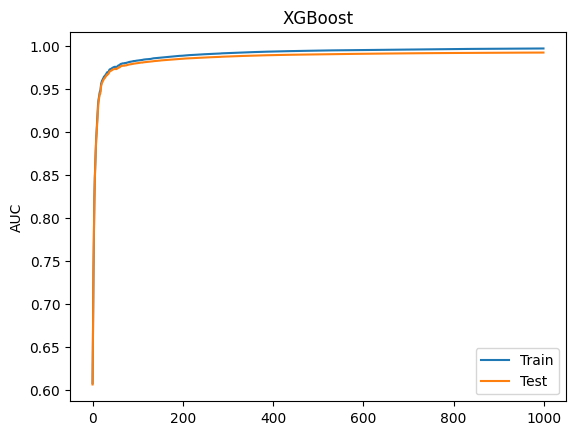

In [39]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost')
plt.show()

In [52]:
xgb = XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 6,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)



In [53]:
%%time
xgb.fit(Xtrain_tfidf, ytrain)

CPU times: user 16min 8s, sys: 1min 30s, total: 17min 39s
Wall time: 2min 28s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [54]:
ypred_xgb=xgb.predict(Xtest_tfidf)

In [55]:
tr_acc_xgb = xgb.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb =  accuracy_score(ytest,ypred_xgb) * 100
print(tr_acc_xgb,test_acc_xgb)

89.72258590788509 88.40238957798518


In [73]:
print(classification_report(ytest,ypred_xgb, digits=3))

              precision    recall  f1-score   support

           0      0.938     0.912     0.925     36429
           1      0.879     0.915     0.897     42166
           2      0.774     0.830     0.801     10408
           3      0.933     0.841     0.884     17329
           4      0.887     0.803     0.843     14270
           5      0.673     0.915     0.776      4441

    accuracy                          0.884    125043
   macro avg      0.847     0.869     0.854    125043
weighted avg      0.889     0.884     0.885    125043



In [74]:
pickle.dump(xgb, open('../models/xgb_Basic.pkl', 'wb'))

Tuning max_depth and min_child_weight

In [76]:
xgb_hp1=XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=5,
                      min_child_weight=1, objective= 'multi:softmax', num_class= 6,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, scale_pos_weight=1, seed=27)



In [77]:
param_grid1={ 'max_depth':range(3,10,2),
              'min_child_weight':[1,2,3,4,5]}

In [86]:
grid_search1 = GridSearchCV(xgb_hp1, param_grid1, scoring="f1_macro", n_jobs=-1, cv=2)


In [87]:
%%time
grid_result1 = grid_search1.fit(Xtrain_tfidf, ytrain)

[15:58:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:03:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:15:20] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:25:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[15:58:56] WARNING: /Users/runner/work/xgboost/xgboost/

In [88]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))


Best: 0.853001 using {'max_depth': 7, 'min_child_weight': 4}
[15:58:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:03:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:11:09] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:21:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.

[16:35:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not u

In [89]:
grid_result1.cv_results_['mean_test_score']

array([0.83922072, 0.83923275, 0.83920558, 0.83858942, 0.83807668,
       0.85118783, 0.85178591, 0.85174083, 0.85168853, 0.8509346 ,
       0.85172478, 0.85256198, 0.8523386 , 0.85300137, 0.8523533 ,
       0.84924185, 0.84997707, 0.85111656, 0.85137443, 0.85193105])

In [90]:
xgb_hp2=XGBClassifier(learning_rate =0.1, n_estimators=200,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0,  subsample=0.8, colsample_bytree=0.8, seed=27)



In [91]:
param_grid2={
            'max_depth':[6,7,8]
            

}

grid_search2 = GridSearchCV(xgb_hp2, param_grid2, scoring="f1_macro", n_jobs=-1, cv=2)



In [92]:
%%time
grid_result2 = grid_search2.fit(Xtrain_tfidf, ytrain)

CPU times: user 21min 57s, sys: 2min 18s, total: 24min 16s
Wall time: 13min 3s


In [93]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print(grid_result2.cv_results_['mean_test_score'])


Best: 0.853001 using {'max_depth': 7}
[0.85298395 0.85300137 0.85206559]


In [94]:
xgb_hp3=XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      subsample=0.8, colsample_bytree=0.8, seed=27)


In [95]:
param_grid3={
 'gamma':[i/10.0 for i in range(0,5)]
}
grid_search3 = GridSearchCV(xgb_hp3, param_grid3, scoring="f1_macro", n_jobs=-1, cv=2)


In [96]:
%%time
grid_result3 = grid_search3.fit(Xtrain_tfidf, ytrain)

CPU times: user 21min 59s, sys: 2min 22s, total: 24min 21s
Wall time: 21min 54s


In [97]:
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
print(grid_result3.cv_results_['mean_test_score'])


Best: 0.853008 using {'gamma': 0.2}
[0.85300137 0.85293987 0.853008   0.85284982 0.85271638]


Tuning subsample and colsample_bytree

In [98]:
xgb_hp4=XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2, seed=27)


In [99]:
param_grid4={
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
grid_search4 = GridSearchCV(xgb_hp4, param_grid4, scoring="f1_macro", n_jobs=-1, cv=2)


In [101]:
%%time
grid_result4 = grid_search4.fit(Xtrain_tfidf, ytrain)

CPU times: user 25min 33s, sys: 2min 7s, total: 27min 40s
Wall time: 43min 27s


In [102]:
print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
print(grid_result4.cv_results_['mean_test_score'])


Best: 0.854531 using {'colsample_bytree': 0.9, 'subsample': 0.9}
[0.85230017 0.85253716 0.85243296 0.85300945 0.85251638 0.85300372
 0.85317806 0.85386646 0.85258505 0.85345792 0.853008   0.85415183
 0.85236165 0.85350096 0.85326193 0.85453078]


In [105]:
param_grid4_small={
 'subsample':[i/100.0 for i in range(85,100,5)],
 'colsample_bytree':[i/100.0 for i in range(85,100,5)]
}
grid_search4_small = GridSearchCV(xgb_hp4, param_grid4_small, scoring="f1_macro", n_jobs=-1, cv=2)


In [106]:
%%time
grid_result4_small = grid_search4_small.fit(Xtrain_tfidf, ytrain)

CPU times: user 24min 53s, sys: 1min 45s, total: 26min 38s
Wall time: 37min 36s


In [107]:
print("Best: %f using %s" % (grid_result4_small.best_score_, grid_result4_small.best_params_))
print(grid_result4_small.cv_results_['mean_test_score'])


Best: 0.856011 using {'colsample_bytree': 0.9, 'subsample': 0.95}
[0.85370459 0.85428601 0.85508681 0.85388121 0.85453078 0.8560106
 0.85382888 0.85440994 0.85575911]


Applying the tuned hyper parameters to the model

In [108]:
xgb_clf= XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2,  subsample=0.95, colsample_bytree=0.9, seed=27)

In [109]:
xgb_clf.fit(Xtrain_tfidf, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [117]:
ypred_xgb_clf=xgb_clf.predict(Xtest_tfidf)

In [118]:
tr_acc_xgb_clf = xgb_clf.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb_clf =  accuracy_score(ytest,ypred_xgb_clf) * 100
print(tr_acc_xgb_clf,test_acc_xgb_clf)

90.5862917543511 88.82144542277457


In [188]:
pickle.dump(xgb_clf, open('../models/xgb_hp.pkl', 'wb'))

Seems like it is overfitting compared to initial results. Regularizing the hyper parameters.

In [112]:
xgb_hp5= XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2,  subsample=0.95, colsample_bytree=0.9, seed=27)

param_grid5={
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
grid_search5 = GridSearchCV(xgb_hp5, param_grid5, scoring="f1_macro", n_jobs=-1, cv=2)


In [113]:
%%time
grid_result5 = grid_search5.fit(Xtrain_tfidf, ytrain)

CPU times: user 25min 18s, sys: 2min 5s, total: 27min 24s
Wall time: 25min 57s


In [114]:
print("Best: %f using %s" % (grid_result5.best_score_, grid_result5.best_params_))
print(grid_result5.cv_results_['mean_test_score'])


Best: 0.855988 using {'reg_alpha': 1e-05}
[0.85598763 0.85550882 0.85533781 0.85569911 0.823176  ]


In [115]:
xgb_clf1= XGBClassifier(learning_rate =0.1, n_estimators=200, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2,  subsample=0.95, colsample_bytree=0.9,reg_alpha= 1e-05, seed=27)

In [116]:
xgb_clf1.fit(Xtrain_tfidf, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [119]:
ypred_xgb_clf1=xgb_clf1.predict(Xtest_tfidf)

In [120]:
tr_acc_xgb_clf1 = xgb_clf1.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb_clf1 =  accuracy_score(ytest,ypred_xgb_clf1) * 100
print(tr_acc_xgb_clf1,test_acc_xgb_clf1)

90.5890336776732 88.7934550514623


Reducing learning rate and adding more trees

In [121]:
xgb_lr=XGBClassifier(learning_rate =0.01, n_estimators=2000, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2,  subsample=0.95, colsample_bytree=0.9, seed=27)

In [122]:
eval_set = [(Xtrain_tfidf, ytrain),(Xtest_tfidf, ytest)]

In [123]:
xgb_lr.fit(Xtrain_tfidf, ytrain, eval_metric='auc', eval_set=eval_set,early_stopping_rounds=50, verbose=True)


/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/phanisingaraju/opt/anaconda3/envs/emotionanalysis_env/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.64306	validation_1-auc:0.64045
[1]	validation_0-auc:0.68376	validation_1-auc:0.68096
[2]	validation_0-auc:0.71056	validation_1-auc:0.70686
[3]	validation_0-auc:0.72915	validation_1-auc:0.72599
[4]	validation_0-auc:0.74300	validation_1-auc:0.73970
[5]	validation_0-auc:0.76014	validation_1-auc:0.75727
[6]	validation_0-auc:0.76953	validation_1-auc:0.76696
[7]	validation_0-auc:0.78277	validation_1-auc:0.78058
[8]	validation_0-auc:0.79764	validation_1-auc:0.79561
[9]	validation_0-auc:0.80826	validation_1-auc:0.80612
[10]	validation_0-auc:0.81974	validation_1-auc:0.81807
[11]	validation_0-auc:0.83240	validation_1-auc:0.83063
[12]	validation_0-auc:0.84537	validation_1-auc:0.84394
[13]	validation_0-auc:0.85025	validation_1-auc:0.84883
[14]	validation_0-auc:0.85532	validation_1-auc:0.85400
[15]	validation_0-auc:0.85785	validation_1-auc:0.85649
[16]	validation_0-auc:0.86222	validation_1-auc:0.86076
[17]	validation_0-auc:0.86803	validation_1-auc:0.86689
[18]	validation_0-au

[149]	validation_0-auc:0.95861	validation_1-auc:0.95594
[150]	validation_0-auc:0.95873	validation_1-auc:0.95606
[151]	validation_0-auc:0.95876	validation_1-auc:0.95610
[152]	validation_0-auc:0.95908	validation_1-auc:0.95641
[153]	validation_0-auc:0.95952	validation_1-auc:0.95684
[154]	validation_0-auc:0.95957	validation_1-auc:0.95687
[155]	validation_0-auc:0.95955	validation_1-auc:0.95685
[156]	validation_0-auc:0.95984	validation_1-auc:0.95711
[157]	validation_0-auc:0.96045	validation_1-auc:0.95771
[158]	validation_0-auc:0.96050	validation_1-auc:0.95776
[159]	validation_0-auc:0.96068	validation_1-auc:0.95795
[160]	validation_0-auc:0.96071	validation_1-auc:0.95799
[161]	validation_0-auc:0.96092	validation_1-auc:0.95821
[162]	validation_0-auc:0.96119	validation_1-auc:0.95849
[163]	validation_0-auc:0.96143	validation_1-auc:0.95873
[164]	validation_0-auc:0.96148	validation_1-auc:0.95876
[165]	validation_0-auc:0.96167	validation_1-auc:0.95892
[166]	validation_0-auc:0.96167	validation_1-auc:

[296]	validation_0-auc:0.97313	validation_1-auc:0.97056
[297]	validation_0-auc:0.97316	validation_1-auc:0.97058
[298]	validation_0-auc:0.97325	validation_1-auc:0.97067
[299]	validation_0-auc:0.97332	validation_1-auc:0.97076
[300]	validation_0-auc:0.97337	validation_1-auc:0.97080
[301]	validation_0-auc:0.97340	validation_1-auc:0.97082
[302]	validation_0-auc:0.97340	validation_1-auc:0.97082
[303]	validation_0-auc:0.97352	validation_1-auc:0.97095
[304]	validation_0-auc:0.97353	validation_1-auc:0.97094
[305]	validation_0-auc:0.97354	validation_1-auc:0.97094
[306]	validation_0-auc:0.97358	validation_1-auc:0.97099
[307]	validation_0-auc:0.97363	validation_1-auc:0.97105
[308]	validation_0-auc:0.97365	validation_1-auc:0.97106
[309]	validation_0-auc:0.97369	validation_1-auc:0.97109
[310]	validation_0-auc:0.97380	validation_1-auc:0.97120
[311]	validation_0-auc:0.97397	validation_1-auc:0.97136
[312]	validation_0-auc:0.97401	validation_1-auc:0.97140
[313]	validation_0-auc:0.97406	validation_1-auc:

[443]	validation_0-auc:0.97856	validation_1-auc:0.97564
[444]	validation_0-auc:0.97859	validation_1-auc:0.97566
[445]	validation_0-auc:0.97861	validation_1-auc:0.97569
[446]	validation_0-auc:0.97864	validation_1-auc:0.97571
[447]	validation_0-auc:0.97864	validation_1-auc:0.97572
[448]	validation_0-auc:0.97869	validation_1-auc:0.97576
[449]	validation_0-auc:0.97874	validation_1-auc:0.97581
[450]	validation_0-auc:0.97877	validation_1-auc:0.97585
[451]	validation_0-auc:0.97881	validation_1-auc:0.97588
[452]	validation_0-auc:0.97881	validation_1-auc:0.97588
[453]	validation_0-auc:0.97885	validation_1-auc:0.97592
[454]	validation_0-auc:0.97886	validation_1-auc:0.97591
[455]	validation_0-auc:0.97889	validation_1-auc:0.97595
[456]	validation_0-auc:0.97890	validation_1-auc:0.97595
[457]	validation_0-auc:0.97897	validation_1-auc:0.97602
[458]	validation_0-auc:0.97900	validation_1-auc:0.97605
[459]	validation_0-auc:0.97903	validation_1-auc:0.97607
[460]	validation_0-auc:0.97904	validation_1-auc:

[590]	validation_0-auc:0.98127	validation_1-auc:0.97814
[591]	validation_0-auc:0.98129	validation_1-auc:0.97816
[592]	validation_0-auc:0.98131	validation_1-auc:0.97818
[593]	validation_0-auc:0.98131	validation_1-auc:0.97818
[594]	validation_0-auc:0.98132	validation_1-auc:0.97819
[595]	validation_0-auc:0.98132	validation_1-auc:0.97819
[596]	validation_0-auc:0.98132	validation_1-auc:0.97820
[597]	validation_0-auc:0.98133	validation_1-auc:0.97821
[598]	validation_0-auc:0.98135	validation_1-auc:0.97822
[599]	validation_0-auc:0.98136	validation_1-auc:0.97823
[600]	validation_0-auc:0.98137	validation_1-auc:0.97824
[601]	validation_0-auc:0.98138	validation_1-auc:0.97824
[602]	validation_0-auc:0.98143	validation_1-auc:0.97828
[603]	validation_0-auc:0.98145	validation_1-auc:0.97830
[604]	validation_0-auc:0.98146	validation_1-auc:0.97831
[605]	validation_0-auc:0.98147	validation_1-auc:0.97833
[606]	validation_0-auc:0.98149	validation_1-auc:0.97835
[607]	validation_0-auc:0.98152	validation_1-auc:

[737]	validation_0-auc:0.98321	validation_1-auc:0.97995
[738]	validation_0-auc:0.98322	validation_1-auc:0.97996
[739]	validation_0-auc:0.98322	validation_1-auc:0.97996
[740]	validation_0-auc:0.98322	validation_1-auc:0.97996
[741]	validation_0-auc:0.98322	validation_1-auc:0.97996
[742]	validation_0-auc:0.98323	validation_1-auc:0.97997
[743]	validation_0-auc:0.98324	validation_1-auc:0.97997
[744]	validation_0-auc:0.98325	validation_1-auc:0.97999
[745]	validation_0-auc:0.98326	validation_1-auc:0.98000
[746]	validation_0-auc:0.98328	validation_1-auc:0.98001
[747]	validation_0-auc:0.98328	validation_1-auc:0.98001
[748]	validation_0-auc:0.98328	validation_1-auc:0.98002
[749]	validation_0-auc:0.98330	validation_1-auc:0.98003
[750]	validation_0-auc:0.98331	validation_1-auc:0.98004
[751]	validation_0-auc:0.98331	validation_1-auc:0.98003
[752]	validation_0-auc:0.98332	validation_1-auc:0.98005
[753]	validation_0-auc:0.98333	validation_1-auc:0.98006
[754]	validation_0-auc:0.98334	validation_1-auc:

[884]	validation_0-auc:0.98475	validation_1-auc:0.98138
[885]	validation_0-auc:0.98475	validation_1-auc:0.98137
[886]	validation_0-auc:0.98477	validation_1-auc:0.98139
[887]	validation_0-auc:0.98478	validation_1-auc:0.98141
[888]	validation_0-auc:0.98479	validation_1-auc:0.98141
[889]	validation_0-auc:0.98479	validation_1-auc:0.98142
[890]	validation_0-auc:0.98480	validation_1-auc:0.98143
[891]	validation_0-auc:0.98483	validation_1-auc:0.98145
[892]	validation_0-auc:0.98483	validation_1-auc:0.98145
[893]	validation_0-auc:0.98483	validation_1-auc:0.98145
[894]	validation_0-auc:0.98485	validation_1-auc:0.98147
[895]	validation_0-auc:0.98486	validation_1-auc:0.98148
[896]	validation_0-auc:0.98487	validation_1-auc:0.98148
[897]	validation_0-auc:0.98488	validation_1-auc:0.98149
[898]	validation_0-auc:0.98488	validation_1-auc:0.98150
[899]	validation_0-auc:0.98490	validation_1-auc:0.98151
[900]	validation_0-auc:0.98491	validation_1-auc:0.98152
[901]	validation_0-auc:0.98492	validation_1-auc:

[1030]	validation_0-auc:0.98605	validation_1-auc:0.98260
[1031]	validation_0-auc:0.98606	validation_1-auc:0.98261
[1032]	validation_0-auc:0.98606	validation_1-auc:0.98261
[1033]	validation_0-auc:0.98606	validation_1-auc:0.98261
[1034]	validation_0-auc:0.98606	validation_1-auc:0.98261
[1035]	validation_0-auc:0.98608	validation_1-auc:0.98262
[1036]	validation_0-auc:0.98609	validation_1-auc:0.98264
[1037]	validation_0-auc:0.98610	validation_1-auc:0.98264
[1038]	validation_0-auc:0.98611	validation_1-auc:0.98266
[1039]	validation_0-auc:0.98612	validation_1-auc:0.98267
[1040]	validation_0-auc:0.98613	validation_1-auc:0.98268
[1041]	validation_0-auc:0.98614	validation_1-auc:0.98269
[1042]	validation_0-auc:0.98615	validation_1-auc:0.98269
[1043]	validation_0-auc:0.98616	validation_1-auc:0.98270
[1044]	validation_0-auc:0.98618	validation_1-auc:0.98271
[1045]	validation_0-auc:0.98618	validation_1-auc:0.98272
[1046]	validation_0-auc:0.98619	validation_1-auc:0.98273
[1047]	validation_0-auc:0.98619

[1174]	validation_0-auc:0.98706	validation_1-auc:0.98353
[1175]	validation_0-auc:0.98707	validation_1-auc:0.98354
[1176]	validation_0-auc:0.98708	validation_1-auc:0.98355
[1177]	validation_0-auc:0.98708	validation_1-auc:0.98355
[1178]	validation_0-auc:0.98708	validation_1-auc:0.98355
[1179]	validation_0-auc:0.98709	validation_1-auc:0.98356
[1180]	validation_0-auc:0.98710	validation_1-auc:0.98357
[1181]	validation_0-auc:0.98711	validation_1-auc:0.98357
[1182]	validation_0-auc:0.98711	validation_1-auc:0.98358
[1183]	validation_0-auc:0.98711	validation_1-auc:0.98358
[1184]	validation_0-auc:0.98711	validation_1-auc:0.98358
[1185]	validation_0-auc:0.98713	validation_1-auc:0.98360
[1186]	validation_0-auc:0.98714	validation_1-auc:0.98361
[1187]	validation_0-auc:0.98714	validation_1-auc:0.98361
[1188]	validation_0-auc:0.98714	validation_1-auc:0.98361
[1189]	validation_0-auc:0.98715	validation_1-auc:0.98361
[1190]	validation_0-auc:0.98716	validation_1-auc:0.98362
[1191]	validation_0-auc:0.98716

[1318]	validation_0-auc:0.98794	validation_1-auc:0.98434
[1319]	validation_0-auc:0.98795	validation_1-auc:0.98434
[1320]	validation_0-auc:0.98795	validation_1-auc:0.98434
[1321]	validation_0-auc:0.98796	validation_1-auc:0.98435
[1322]	validation_0-auc:0.98797	validation_1-auc:0.98436
[1323]	validation_0-auc:0.98798	validation_1-auc:0.98436
[1324]	validation_0-auc:0.98798	validation_1-auc:0.98437
[1325]	validation_0-auc:0.98799	validation_1-auc:0.98438
[1326]	validation_0-auc:0.98799	validation_1-auc:0.98438
[1327]	validation_0-auc:0.98799	validation_1-auc:0.98438
[1328]	validation_0-auc:0.98801	validation_1-auc:0.98439
[1329]	validation_0-auc:0.98801	validation_1-auc:0.98440
[1330]	validation_0-auc:0.98802	validation_1-auc:0.98440
[1331]	validation_0-auc:0.98803	validation_1-auc:0.98441
[1332]	validation_0-auc:0.98804	validation_1-auc:0.98442
[1333]	validation_0-auc:0.98804	validation_1-auc:0.98442
[1334]	validation_0-auc:0.98804	validation_1-auc:0.98443
[1335]	validation_0-auc:0.98804

[1462]	validation_0-auc:0.98875	validation_1-auc:0.98505
[1463]	validation_0-auc:0.98876	validation_1-auc:0.98505
[1464]	validation_0-auc:0.98877	validation_1-auc:0.98506
[1465]	validation_0-auc:0.98878	validation_1-auc:0.98508
[1466]	validation_0-auc:0.98879	validation_1-auc:0.98509
[1467]	validation_0-auc:0.98879	validation_1-auc:0.98509
[1468]	validation_0-auc:0.98880	validation_1-auc:0.98510
[1469]	validation_0-auc:0.98880	validation_1-auc:0.98510
[1470]	validation_0-auc:0.98881	validation_1-auc:0.98511
[1471]	validation_0-auc:0.98882	validation_1-auc:0.98511
[1472]	validation_0-auc:0.98883	validation_1-auc:0.98512
[1473]	validation_0-auc:0.98883	validation_1-auc:0.98513
[1474]	validation_0-auc:0.98884	validation_1-auc:0.98513
[1475]	validation_0-auc:0.98885	validation_1-auc:0.98514
[1476]	validation_0-auc:0.98885	validation_1-auc:0.98514
[1477]	validation_0-auc:0.98886	validation_1-auc:0.98515
[1478]	validation_0-auc:0.98886	validation_1-auc:0.98515
[1479]	validation_0-auc:0.98886

[1606]	validation_0-auc:0.98945	validation_1-auc:0.98567
[1607]	validation_0-auc:0.98946	validation_1-auc:0.98567
[1608]	validation_0-auc:0.98946	validation_1-auc:0.98568
[1609]	validation_0-auc:0.98947	validation_1-auc:0.98568
[1610]	validation_0-auc:0.98947	validation_1-auc:0.98569
[1611]	validation_0-auc:0.98948	validation_1-auc:0.98570
[1612]	validation_0-auc:0.98949	validation_1-auc:0.98571
[1613]	validation_0-auc:0.98950	validation_1-auc:0.98571
[1614]	validation_0-auc:0.98950	validation_1-auc:0.98571
[1615]	validation_0-auc:0.98950	validation_1-auc:0.98572
[1616]	validation_0-auc:0.98951	validation_1-auc:0.98572
[1617]	validation_0-auc:0.98951	validation_1-auc:0.98572
[1618]	validation_0-auc:0.98952	validation_1-auc:0.98573
[1619]	validation_0-auc:0.98952	validation_1-auc:0.98573
[1620]	validation_0-auc:0.98953	validation_1-auc:0.98574
[1621]	validation_0-auc:0.98953	validation_1-auc:0.98574
[1622]	validation_0-auc:0.98954	validation_1-auc:0.98575
[1623]	validation_0-auc:0.98954

[1750]	validation_0-auc:0.99007	validation_1-auc:0.98621
[1751]	validation_0-auc:0.99008	validation_1-auc:0.98622
[1752]	validation_0-auc:0.99008	validation_1-auc:0.98622
[1753]	validation_0-auc:0.99009	validation_1-auc:0.98622
[1754]	validation_0-auc:0.99009	validation_1-auc:0.98623
[1755]	validation_0-auc:0.99009	validation_1-auc:0.98623
[1756]	validation_0-auc:0.99009	validation_1-auc:0.98623
[1757]	validation_0-auc:0.99010	validation_1-auc:0.98623
[1758]	validation_0-auc:0.99010	validation_1-auc:0.98624
[1759]	validation_0-auc:0.99011	validation_1-auc:0.98624
[1760]	validation_0-auc:0.99011	validation_1-auc:0.98624
[1761]	validation_0-auc:0.99011	validation_1-auc:0.98625
[1762]	validation_0-auc:0.99012	validation_1-auc:0.98625
[1763]	validation_0-auc:0.99012	validation_1-auc:0.98625
[1764]	validation_0-auc:0.99013	validation_1-auc:0.98626
[1765]	validation_0-auc:0.99013	validation_1-auc:0.98626
[1766]	validation_0-auc:0.99013	validation_1-auc:0.98626
[1767]	validation_0-auc:0.99014

[1894]	validation_0-auc:0.99061	validation_1-auc:0.98669
[1895]	validation_0-auc:0.99062	validation_1-auc:0.98669
[1896]	validation_0-auc:0.99062	validation_1-auc:0.98670
[1897]	validation_0-auc:0.99062	validation_1-auc:0.98670
[1898]	validation_0-auc:0.99063	validation_1-auc:0.98671
[1899]	validation_0-auc:0.99063	validation_1-auc:0.98671
[1900]	validation_0-auc:0.99064	validation_1-auc:0.98671
[1901]	validation_0-auc:0.99064	validation_1-auc:0.98671
[1902]	validation_0-auc:0.99064	validation_1-auc:0.98672
[1903]	validation_0-auc:0.99064	validation_1-auc:0.98672
[1904]	validation_0-auc:0.99065	validation_1-auc:0.98672
[1905]	validation_0-auc:0.99065	validation_1-auc:0.98673
[1906]	validation_0-auc:0.99065	validation_1-auc:0.98673
[1907]	validation_0-auc:0.99066	validation_1-auc:0.98673
[1908]	validation_0-auc:0.99066	validation_1-auc:0.98673
[1909]	validation_0-auc:0.99067	validation_1-auc:0.98674
[1910]	validation_0-auc:0.99067	validation_1-auc:0.98674
[1911]	validation_0-auc:0.99067

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [124]:
results = xgb_lr.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

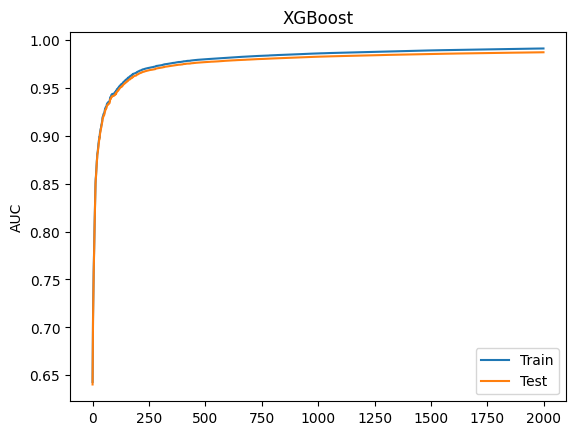

In [125]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost')
plt.show()

In [143]:
xgb_lr.fit(Xtrain_tfidf, ytrain, eval_metric='merror', eval_set=eval_set,early_stopping_rounds=50, verbose=True)


[0]	validation_0-merror:0.54988	validation_1-merror:0.55412
[1]	validation_0-merror:0.51276	validation_1-merror:0.51665
[2]	validation_0-merror:0.49168	validation_1-merror:0.49733
[3]	validation_0-merror:0.48002	validation_1-merror:0.48500
[4]	validation_0-merror:0.48429	validation_1-merror:0.48942
[5]	validation_0-merror:0.47036	validation_1-merror:0.47477
[6]	validation_0-merror:0.45358	validation_1-merror:0.45878
[7]	validation_0-merror:0.44471	validation_1-merror:0.44928
[8]	validation_0-merror:0.44334	validation_1-merror:0.44752
[9]	validation_0-merror:0.43265	validation_1-merror:0.43769
[10]	validation_0-merror:0.41838	validation_1-merror:0.42325
[11]	validation_0-merror:0.41838	validation_1-merror:0.42370
[12]	validation_0-merror:0.41045	validation_1-merror:0.41555
[13]	validation_0-merror:0.40247	validation_1-merror:0.40696
[14]	validation_0-merror:0.39544	validation_1-merror:0.40017
[15]	validation_0-merror:0.39847	validation_1-merror:0.40314
[16]	validation_0-merror:0.41223	v

[134]	validation_0-merror:0.26686	validation_1-merror:0.27461
[135]	validation_0-merror:0.26558	validation_1-merror:0.27324
[136]	validation_0-merror:0.26211	validation_1-merror:0.26964
[137]	validation_0-merror:0.26429	validation_1-merror:0.27175
[138]	validation_0-merror:0.26236	validation_1-merror:0.26972
[139]	validation_0-merror:0.26224	validation_1-merror:0.26973
[140]	validation_0-merror:0.26284	validation_1-merror:0.27028
[141]	validation_0-merror:0.26328	validation_1-merror:0.27061
[142]	validation_0-merror:0.26256	validation_1-merror:0.27013
[143]	validation_0-merror:0.26222	validation_1-merror:0.26976
[144]	validation_0-merror:0.26144	validation_1-merror:0.26885
[145]	validation_0-merror:0.26135	validation_1-merror:0.26896
[146]	validation_0-merror:0.26182	validation_1-merror:0.26941
[147]	validation_0-merror:0.26208	validation_1-merror:0.26952
[148]	validation_0-merror:0.26274	validation_1-merror:0.27030
[149]	validation_0-merror:0.25918	validation_1-merror:0.26688
[150]	va

[267]	validation_0-merror:0.21241	validation_1-merror:0.22092
[268]	validation_0-merror:0.21150	validation_1-merror:0.22015
[269]	validation_0-merror:0.21120	validation_1-merror:0.21991
[270]	validation_0-merror:0.21129	validation_1-merror:0.21981
[271]	validation_0-merror:0.21147	validation_1-merror:0.21992
[272]	validation_0-merror:0.21125	validation_1-merror:0.21965
[273]	validation_0-merror:0.21123	validation_1-merror:0.21962
[274]	validation_0-merror:0.21129	validation_1-merror:0.21960
[275]	validation_0-merror:0.21090	validation_1-merror:0.21931
[276]	validation_0-merror:0.21097	validation_1-merror:0.21932
[277]	validation_0-merror:0.21049	validation_1-merror:0.21897
[278]	validation_0-merror:0.21031	validation_1-merror:0.21864
[279]	validation_0-merror:0.21030	validation_1-merror:0.21860
[280]	validation_0-merror:0.20999	validation_1-merror:0.21836
[281]	validation_0-merror:0.20976	validation_1-merror:0.21835
[282]	validation_0-merror:0.20969	validation_1-merror:0.21828
[283]	va

[400]	validation_0-merror:0.18244	validation_1-merror:0.19223
[401]	validation_0-merror:0.18230	validation_1-merror:0.19199
[402]	validation_0-merror:0.18224	validation_1-merror:0.19194
[403]	validation_0-merror:0.18221	validation_1-merror:0.19176
[404]	validation_0-merror:0.18211	validation_1-merror:0.19165
[405]	validation_0-merror:0.18185	validation_1-merror:0.19149
[406]	validation_0-merror:0.18181	validation_1-merror:0.19147
[407]	validation_0-merror:0.18172	validation_1-merror:0.19136
[408]	validation_0-merror:0.18165	validation_1-merror:0.19135
[409]	validation_0-merror:0.18156	validation_1-merror:0.19132
[410]	validation_0-merror:0.18145	validation_1-merror:0.19117
[411]	validation_0-merror:0.18071	validation_1-merror:0.19031
[412]	validation_0-merror:0.18078	validation_1-merror:0.19032
[413]	validation_0-merror:0.18021	validation_1-merror:0.18983
[414]	validation_0-merror:0.18018	validation_1-merror:0.18985
[415]	validation_0-merror:0.17997	validation_1-merror:0.18966
[416]	va

[533]	validation_0-merror:0.15545	validation_1-merror:0.16528
[534]	validation_0-merror:0.15538	validation_1-merror:0.16514
[535]	validation_0-merror:0.15546	validation_1-merror:0.16514
[536]	validation_0-merror:0.15542	validation_1-merror:0.16511
[537]	validation_0-merror:0.15541	validation_1-merror:0.16508
[538]	validation_0-merror:0.15470	validation_1-merror:0.16438
[539]	validation_0-merror:0.15469	validation_1-merror:0.16430
[540]	validation_0-merror:0.15449	validation_1-merror:0.16414
[541]	validation_0-merror:0.15440	validation_1-merror:0.16402
[542]	validation_0-merror:0.15441	validation_1-merror:0.16410
[543]	validation_0-merror:0.15445	validation_1-merror:0.16416
[544]	validation_0-merror:0.15437	validation_1-merror:0.16406
[545]	validation_0-merror:0.15430	validation_1-merror:0.16393
[546]	validation_0-merror:0.15431	validation_1-merror:0.16393
[547]	validation_0-merror:0.15482	validation_1-merror:0.16453
[548]	validation_0-merror:0.15408	validation_1-merror:0.16368
[549]	va

[666]	validation_0-merror:0.13798	validation_1-merror:0.14708
[667]	validation_0-merror:0.13798	validation_1-merror:0.14704
[668]	validation_0-merror:0.13793	validation_1-merror:0.14705
[669]	validation_0-merror:0.13792	validation_1-merror:0.14707
[670]	validation_0-merror:0.13785	validation_1-merror:0.14689
[671]	validation_0-merror:0.13765	validation_1-merror:0.14675
[672]	validation_0-merror:0.13764	validation_1-merror:0.14675
[673]	validation_0-merror:0.13762	validation_1-merror:0.14678
[674]	validation_0-merror:0.13751	validation_1-merror:0.14677
[675]	validation_0-merror:0.13749	validation_1-merror:0.14678
[676]	validation_0-merror:0.13746	validation_1-merror:0.14678
[677]	validation_0-merror:0.13743	validation_1-merror:0.14675
[678]	validation_0-merror:0.13741	validation_1-merror:0.14669
[679]	validation_0-merror:0.13738	validation_1-merror:0.14672
[680]	validation_0-merror:0.13734	validation_1-merror:0.14664
[681]	validation_0-merror:0.13741	validation_1-merror:0.14682
[682]	va

[799]	validation_0-merror:0.12624	validation_1-merror:0.13547
[800]	validation_0-merror:0.12636	validation_1-merror:0.13548
[801]	validation_0-merror:0.12631	validation_1-merror:0.13547
[802]	validation_0-merror:0.12619	validation_1-merror:0.13537
[803]	validation_0-merror:0.12620	validation_1-merror:0.13537
[804]	validation_0-merror:0.12558	validation_1-merror:0.13489
[805]	validation_0-merror:0.12556	validation_1-merror:0.13491
[806]	validation_0-merror:0.12491	validation_1-merror:0.13427
[807]	validation_0-merror:0.12484	validation_1-merror:0.13422
[808]	validation_0-merror:0.12477	validation_1-merror:0.13419
[809]	validation_0-merror:0.12474	validation_1-merror:0.13415
[810]	validation_0-merror:0.12474	validation_1-merror:0.13411
[811]	validation_0-merror:0.12475	validation_1-merror:0.13411
[812]	validation_0-merror:0.12481	validation_1-merror:0.13411
[813]	validation_0-merror:0.12474	validation_1-merror:0.13419
[814]	validation_0-merror:0.12473	validation_1-merror:0.13415
[815]	va

[932]	validation_0-merror:0.11805	validation_1-merror:0.12891
[933]	validation_0-merror:0.11800	validation_1-merror:0.12901
[934]	validation_0-merror:0.11799	validation_1-merror:0.12896
[935]	validation_0-merror:0.11799	validation_1-merror:0.12901
[936]	validation_0-merror:0.11814	validation_1-merror:0.12900
[937]	validation_0-merror:0.11811	validation_1-merror:0.12899
[938]	validation_0-merror:0.11786	validation_1-merror:0.12869
[939]	validation_0-merror:0.11784	validation_1-merror:0.12870
[940]	validation_0-merror:0.11782	validation_1-merror:0.12868
[941]	validation_0-merror:0.11781	validation_1-merror:0.12867
[942]	validation_0-merror:0.11779	validation_1-merror:0.12863
[943]	validation_0-merror:0.11763	validation_1-merror:0.12829
[944]	validation_0-merror:0.11760	validation_1-merror:0.12821
[945]	validation_0-merror:0.11755	validation_1-merror:0.12825
[946]	validation_0-merror:0.11754	validation_1-merror:0.12823
[947]	validation_0-merror:0.11751	validation_1-merror:0.12827
[948]	va

[1064]	validation_0-merror:0.11353	validation_1-merror:0.12521
[1065]	validation_0-merror:0.11352	validation_1-merror:0.12524
[1066]	validation_0-merror:0.11349	validation_1-merror:0.12514
[1067]	validation_0-merror:0.11350	validation_1-merror:0.12511
[1068]	validation_0-merror:0.11350	validation_1-merror:0.12509
[1069]	validation_0-merror:0.11350	validation_1-merror:0.12504
[1070]	validation_0-merror:0.11343	validation_1-merror:0.12496
[1071]	validation_0-merror:0.11342	validation_1-merror:0.12497
[1072]	validation_0-merror:0.11342	validation_1-merror:0.12497
[1073]	validation_0-merror:0.11343	validation_1-merror:0.12500
[1074]	validation_0-merror:0.11342	validation_1-merror:0.12500
[1075]	validation_0-merror:0.11316	validation_1-merror:0.12473
[1076]	validation_0-merror:0.11321	validation_1-merror:0.12473
[1077]	validation_0-merror:0.11319	validation_1-merror:0.12471
[1078]	validation_0-merror:0.11315	validation_1-merror:0.12473
[1079]	validation_0-merror:0.11300	validation_1-merror:

[1195]	validation_0-merror:0.10881	validation_1-merror:0.12184
[1196]	validation_0-merror:0.10880	validation_1-merror:0.12180
[1197]	validation_0-merror:0.10877	validation_1-merror:0.12178
[1198]	validation_0-merror:0.10874	validation_1-merror:0.12181
[1199]	validation_0-merror:0.10874	validation_1-merror:0.12177
[1200]	validation_0-merror:0.10867	validation_1-merror:0.12181
[1201]	validation_0-merror:0.10868	validation_1-merror:0.12181
[1202]	validation_0-merror:0.10866	validation_1-merror:0.12186
[1203]	validation_0-merror:0.10859	validation_1-merror:0.12202
[1204]	validation_0-merror:0.10857	validation_1-merror:0.12196
[1205]	validation_0-merror:0.10858	validation_1-merror:0.12186
[1206]	validation_0-merror:0.10857	validation_1-merror:0.12189
[1207]	validation_0-merror:0.10841	validation_1-merror:0.12167
[1208]	validation_0-merror:0.10847	validation_1-merror:0.12149
[1209]	validation_0-merror:0.10845	validation_1-merror:0.12150
[1210]	validation_0-merror:0.10839	validation_1-merror:

[1326]	validation_0-merror:0.10585	validation_1-merror:0.11917
[1327]	validation_0-merror:0.10585	validation_1-merror:0.11916
[1328]	validation_0-merror:0.10586	validation_1-merror:0.11917
[1329]	validation_0-merror:0.10583	validation_1-merror:0.11913
[1330]	validation_0-merror:0.10582	validation_1-merror:0.11915
[1331]	validation_0-merror:0.10579	validation_1-merror:0.11915
[1332]	validation_0-merror:0.10577	validation_1-merror:0.11915
[1333]	validation_0-merror:0.10578	validation_1-merror:0.11912
[1334]	validation_0-merror:0.10575	validation_1-merror:0.11909
[1335]	validation_0-merror:0.10575	validation_1-merror:0.11906
[1336]	validation_0-merror:0.10579	validation_1-merror:0.11905
[1337]	validation_0-merror:0.10578	validation_1-merror:0.11905
[1338]	validation_0-merror:0.10575	validation_1-merror:0.11910
[1339]	validation_0-merror:0.10574	validation_1-merror:0.11906
[1340]	validation_0-merror:0.10570	validation_1-merror:0.11909
[1341]	validation_0-merror:0.10567	validation_1-merror:

[1457]	validation_0-merror:0.10250	validation_1-merror:0.11629
[1458]	validation_0-merror:0.10249	validation_1-merror:0.11629
[1459]	validation_0-merror:0.10244	validation_1-merror:0.11629
[1460]	validation_0-merror:0.10243	validation_1-merror:0.11630
[1461]	validation_0-merror:0.10245	validation_1-merror:0.11621
[1462]	validation_0-merror:0.10248	validation_1-merror:0.11618
[1463]	validation_0-merror:0.10246	validation_1-merror:0.11615
[1464]	validation_0-merror:0.10245	validation_1-merror:0.11612
[1465]	validation_0-merror:0.10239	validation_1-merror:0.11623
[1466]	validation_0-merror:0.10236	validation_1-merror:0.11627
[1467]	validation_0-merror:0.10234	validation_1-merror:0.11629
[1468]	validation_0-merror:0.10211	validation_1-merror:0.11613
[1469]	validation_0-merror:0.10211	validation_1-merror:0.11611
[1470]	validation_0-merror:0.10210	validation_1-merror:0.11611
[1471]	validation_0-merror:0.10232	validation_1-merror:0.11624
[1472]	validation_0-merror:0.10230	validation_1-merror:

[1588]	validation_0-merror:0.10071	validation_1-merror:0.11466
[1589]	validation_0-merror:0.10075	validation_1-merror:0.11466
[1590]	validation_0-merror:0.10072	validation_1-merror:0.11472
[1591]	validation_0-merror:0.10072	validation_1-merror:0.11470
[1592]	validation_0-merror:0.10073	validation_1-merror:0.11468
[1593]	validation_0-merror:0.10070	validation_1-merror:0.11466
[1594]	validation_0-merror:0.10071	validation_1-merror:0.11468
[1595]	validation_0-merror:0.10071	validation_1-merror:0.11460
[1596]	validation_0-merror:0.10056	validation_1-merror:0.11437
[1597]	validation_0-merror:0.10056	validation_1-merror:0.11444
[1598]	validation_0-merror:0.10056	validation_1-merror:0.11447
[1599]	validation_0-merror:0.10054	validation_1-merror:0.11445
[1600]	validation_0-merror:0.10054	validation_1-merror:0.11441
[1601]	validation_0-merror:0.10051	validation_1-merror:0.11442
[1602]	validation_0-merror:0.10053	validation_1-merror:0.11439
[1603]	validation_0-merror:0.10048	validation_1-merror:

[1719]	validation_0-merror:0.09920	validation_1-merror:0.11346
[1720]	validation_0-merror:0.09921	validation_1-merror:0.11346
[1721]	validation_0-merror:0.09922	validation_1-merror:0.11348
[1722]	validation_0-merror:0.09921	validation_1-merror:0.11348
[1723]	validation_0-merror:0.09921	validation_1-merror:0.11350
[1724]	validation_0-merror:0.09923	validation_1-merror:0.11346
[1725]	validation_0-merror:0.09921	validation_1-merror:0.11343
[1726]	validation_0-merror:0.09922	validation_1-merror:0.11344
[1727]	validation_0-merror:0.09920	validation_1-merror:0.11337
[1728]	validation_0-merror:0.09921	validation_1-merror:0.11340
[1729]	validation_0-merror:0.09920	validation_1-merror:0.11341
[1730]	validation_0-merror:0.09921	validation_1-merror:0.11338
[1731]	validation_0-merror:0.09918	validation_1-merror:0.11345
[1732]	validation_0-merror:0.09917	validation_1-merror:0.11350
[1733]	validation_0-merror:0.09916	validation_1-merror:0.11350
[1734]	validation_0-merror:0.09915	validation_1-merror:

[1850]	validation_0-merror:0.09719	validation_1-merror:0.11151
[1851]	validation_0-merror:0.09714	validation_1-merror:0.11155
[1852]	validation_0-merror:0.09716	validation_1-merror:0.11155
[1853]	validation_0-merror:0.09715	validation_1-merror:0.11155
[1854]	validation_0-merror:0.09712	validation_1-merror:0.11165
[1855]	validation_0-merror:0.09711	validation_1-merror:0.11164
[1856]	validation_0-merror:0.09711	validation_1-merror:0.11169
[1857]	validation_0-merror:0.09711	validation_1-merror:0.11161
[1858]	validation_0-merror:0.09691	validation_1-merror:0.11209
[1859]	validation_0-merror:0.09691	validation_1-merror:0.11207
[1860]	validation_0-merror:0.09692	validation_1-merror:0.11203
[1861]	validation_0-merror:0.09709	validation_1-merror:0.11163
[1862]	validation_0-merror:0.09703	validation_1-merror:0.11172
[1863]	validation_0-merror:0.09687	validation_1-merror:0.11211
[1864]	validation_0-merror:0.09689	validation_1-merror:0.11203
[1865]	validation_0-merror:0.09687	validation_1-merror:

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=2000, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [145]:
results = xgb_lr.evals_result()
epochs = len(results['validation_0']['merror'])
x_axis = range(0, epochs)

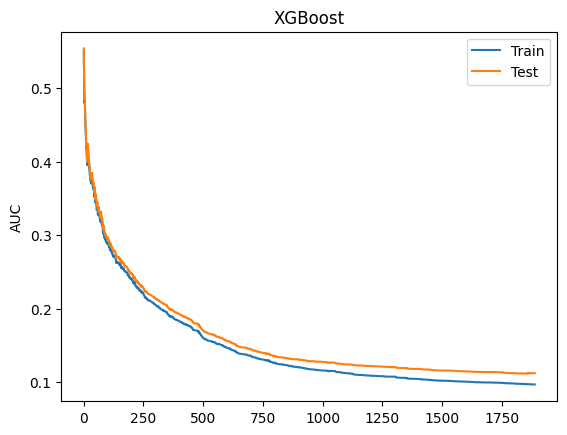

In [146]:
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['merror'], label='Train')
ax.plot(x_axis, results['validation_1']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.title('XGBoost')
plt.show()

In [60]:
xgb_clf2= XGBClassifier(learning_rate =0.01, n_estimators=750, max_depth=7,
                      min_child_weight=4, objective= 'multi:softmax', num_class= 6,
                      gamma=0.2,  subsample=0.95, colsample_bytree=0.9, seed=27)

In [61]:
xgb_clf2.fit(Xtrain_tfidf, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=750, n_jobs=None, num_class=6,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [62]:
ypred_xgb_clf2=xgb_clf2.predict(Xtest_tfidf)

In [63]:
tr_acc_xgb_clf2 = xgb_clf2.score(Xtrain_tfidf, ytrain)*100
test_acc_xgb_clf2 =  accuracy_score(ytest,ypred_xgb_clf2) * 100
print(tr_acc_xgb_clf2,test_acc_xgb_clf2)

86.93679181261696 86.01601049239062
